In [1]:
words = open('../makemore/names.txt', 'r').read().splitlines()

In [7]:
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [27]:
import torch
g = torch.Generator().manual_seed(2147483647)

In [28]:
# creating dataset of bigrams: (x,y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


### Encoding the integers made above from chars

In [29]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes = 27).float()
xenc, xenc.dtype

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 torch.float32)

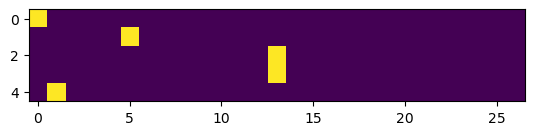

In [30]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

In [34]:
W = torch.randn((27, 27), generator=g)
# (xenc @ W).shape

# 5, 27 @ 27,  1 --> 5, 1
# 5, 27 @ 27, 27 --> 5, 27

torch.Size([5, 27])

In [38]:
logits = xenc @ W # log-counts
counts = logits.exp() # something like N in bigram count model
probs = counts / counts.sum(1, keepdims=True)
probs.shape

torch.Size([5, 27])

In [40]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print("---------------")
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net: ', x)
    print('output probabilities from the neural net: ', probs[i])
    print('label (actual next character): ', y)
    p = probs[i,y]
    print('probability assigned by the net to the correct character: ', p.item())
    logp = torch.log(p)
    print('log likelihood: ', logp.item())
    nll = -logp
    print('negative log likelihood: ', nll.item())
    nlls[i] = nll

print("==============")
print('average negative log likelihood, i.e. loss = ', nlls.mean().item())

---------------
bigram example 1: .e (indexes 0,5)
input to the neural net:  0
output probabilities from the neural net:  tensor([0.0570, 0.0085, 0.0442, 0.0297, 0.0840, 0.0141, 0.0222, 0.0063, 0.0098,
        0.0638, 0.0062, 0.0264, 0.0099, 0.0601, 0.0169, 0.0745, 0.0025, 0.0156,
        0.0456, 0.0726, 0.0243, 0.0781, 0.0769, 0.0333, 0.0115, 0.0348, 0.0713])
label (actual next character):  5
probability assigned by the net to the correct character:  0.014059726148843765
log likelihood:  -4.264441013336182
negative log likelihood:  4.264441013336182
---------------
bigram example 2: em (indexes 5,13)
input to the neural net:  5
output probabilities from the neural net:  tensor([0.0749, 0.0130, 0.0365, 0.0525, 0.0243, 0.0163, 0.0243, 0.0145, 0.0101,
        0.0105, 0.0261, 0.0266, 0.0224, 0.0782, 0.0451, 0.0133, 0.0572, 0.0207,
        0.0304, 0.1077, 0.0666, 0.0122, 0.0315, 0.0146, 0.0508, 0.0371, 0.0823])
label (actual next character):  13
probability assigned by the net to the corre

In [70]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [92]:
# forward pass
logits = xenc @ W # log-counts
counts = logits.exp() # something like N in bigram count model
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5),ys].log().mean() # -ve log likelihood

In [93]:
loss.item()

3.7091541290283203

In [94]:
# probs.shape

In [95]:
# probs[torch.arange(5),ys]#probabilities nn assigns to correct next chars

In [96]:
# backward pass
W.grad = None # set the gradient to 0
loss.backward()

In [97]:
# W.grad.shape, W.shape
# every element in W.grad is telling us the influence of that weight on loss function

In [98]:
# update
W.data += -0.1 * W.grad

### Putting it all together

In [103]:
# creating dataset of bigrams: (x,y)
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [106]:
for i in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float() # input to the network: one-hot encoding
    logits = xenc @ W # log-counts
    counts = logits.exp() # something like N in bigram count model
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean() # -ve log likelihood
    print(loss.item())
    # backward pass
    W.grad = None # set the gradient to 0
    loss.backward()

    # update
    W.data += -50 * W.grad

3.749866247177124
3.3659558296203613
3.150949001312256
3.018296957015991
2.9262173175811768
2.859292507171631
2.808873176574707
2.769418239593506
2.7375104427337646
2.7110233306884766
2.688598871231079
2.6693389415740967
2.65262508392334
2.638009548187256
2.6251513957977295
2.6137807369232178
2.6036765575408936
2.5946543216705322
2.5865609645843506
2.579267740249634
2.5726659297943115
2.5666637420654297
2.561185121536255
2.556164026260376
2.551546812057495
2.547285318374634
2.5433406829833984
2.5396790504455566
2.536271810531616
2.5330939292907715
2.5301244258880615
2.52734375
2.5247366428375244
2.5222878456115723
2.5199849605560303
2.5178165435791016
2.5157716274261475
2.513841390609741
2.512017011642456
2.5102908611297607
2.508655548095703
2.5071051120758057
2.5056331157684326
2.5042340755462646
2.502903461456299
2.501636505126953
2.5004289150238037
2.4992763996124268
2.498176336288452
2.497124671936035
2.4961185455322266
2.495154857635498
2.494231700897217
2.4933464527130127
2.49249

### Adding Regularization
- Equivalent to smoothing in bigram count model, is something called **Regularization**
- It helps in pushing weights towards 0, in order to acheive a more uniform probabilities

In [107]:
# creating dataset of bigrams: (x,y)
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples: ", num)

# initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [108]:
for i in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes = 27).float() # input to the network: one-hot encoding
    logits = xenc @ W # log-counts
    counts = logits.exp() # something like N in bigram count model
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean() + 0.01 * (W**2).mean()
    print(loss.item())
    # backward pass
    W.grad = None # set the gradient to 0
    loss.backward()

    # update
    W.data += -50 * W.grad

3.768618583679199
3.3788065910339355
3.161090850830078
3.027186155319214
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188305854797363
2.696505308151245
2.6773722171783447
2.6608054637908936
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.5822560787200928
2.576429843902588
2.5711236000061035
2.566272735595703
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.5504424571990967
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538721799850464
2.536262035369873
2.5339579582214355
2.5317976474761963
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243704319000244
2.522773027420044
2.521263837814331
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.51269793510437
2.511704921722412
2.5107579231262207
2.509854793548584
2.5089924335479736
2.5081682205200195
2.5073804855346

## Sampling from nn model probs

In [110]:
g = torch.Generator().manual_seed(2147483647)


for i in range(5):
    ix = 0
    out = []
    while True:
        # p = P[ix]
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
